## План работы

**Вступление**   
Проект направлен на сокращение потерь нефтедобычи за счёт анализа событий на оборудовании компании "Роснефть". Исторические данные используются для построения моделей машинного обучения, выделения закономерностей и формирования аналитических выводов, применимых к промышленной эксплуатации. Данные выбраны и закодированы таким образом, что бы не нарушать коммерческой тайны компании. 

**1. Загрузка, первичный анализ и предобработка данных**
- Загрузить предоставленные заказчиком таблицы.
- Изучить структуру данных: количество строк и столбцов, наличие пропусков, типы переменных.
- Сопоставить таблицы с описанием технологического процесса.
- Проверить и обработать пропуски, аномалии и некорректные значения.
- Привести названия столбцов к единому и удобному формату.
- Объединить таблицы в единый датафрейм.

**2. Анализ данных**
- Провести исследовательский анализ объединённого датафрейма.
- Визуализировать структуру инцидентов и распределение признаков.
- Выделить наиболее проблемные группы по критериям:
  - большое количество инцидентов;
  - высокое среднее время простоя.
- Вывести топ-5 групп с наибольшими операционными рисками.

**3. Модель регрессии для оценки потерь**   
Цель: предсказать величину потерь (`full_los`) по характеристикам инцидента.  
Модели: CatBoostRegressor, DecisionTreeRegressor, RandomForestRegressor    
Метрика: MAE (средняя абсолютная ошибка).

**4. Классификатор для предсказания длительности простоев**   
Цель: по признакам события предсказать вероятность того, что простой будет длительным.  
Модель: CatBoostClassifier.  
Метрики: accuracy, classification_report.

**Описания для столбцов:**

| Столбец                         | Описание                                                                                   |
|---------------------------------|--------------------------------------------------------------------------------------------|
| month                           | Месяц, в котором произошёл инцидент                                                        |
| group                           | Нефтегазовая группа (региональное подразделение)                                           |
| company                         | Наименование дочерней компании или филиала                                                 |
| date_off                        | Дата отключения оборудования                                                               |
| time_off                        | Время отключения оборудования                                                              |
| date_on                         | Дата восстановления (включения)                                                            |
| time_on                         | Время восстановления (включения)                                                           |
| time_stop                       | Длительность простоя в формате «ЧЧ:ММ:СС»                                                  |
| oil_well                        | Количество затронутых скважин                                                              |
| unit_p3_pa                      | Давление на третьем контуре, Па                                                            |
| info_autorecovery               | Информация об автоматическом восстановлении работы после аварии                            |
| reason_crush                    | Категория или краткое описание причины отказа                                              |
| unit_name                       | Наименование оборудования или узла, в котором произошёл отказ                               |
| voltage_class                   | Класс напряжения (кВ)                                                                      |
| unit_type                       | Тип оборудования (линия, трансформатор, коммутатор и т. п.)                                 |
| main_unit_off                   | Основной агрегат или установка, отключённая при аварии                                     |
| info_fail                       | Подробное текстовое описание отказа                                                        |
| direct_los                      | Прямые потери (объём остановленной добычи, выработки и т. п.)                              |
| indirect_los                    | Косвенные потери (дополнительные издержки, связанные с простоем)                            |
| full_los                        | Суммарные потери (direct_los + indirect_los)                                               |
| equipment_element               | Конкретный элемент или узел оборудования, где возник отказ                                 |
| year                            | Год ввода оборудования в эксплуатацию                                                      |
| element_type                    | Тип или марка элемента оборудования                                                        |
| element_manufacturer            | Производитель элемента оборудования                                                        |
| last_maintenance_date           | Дата последнего планового ТО и ремонта                                                     |
| maintenance_uptime_pct          | Доля времени работы оборудования после последнего ТО (%)                                   |
| next_maintenance_date           | Запланированная дата следующего ТО и ремонта                                               |
| missed_maintenance_shutdowns    | Число пропущенных плановых остановок для проведения ТО                                     |
| last_diagnosis_date             | Дата последней диагностики оборудования                                                    |
| root_cause                      | Коренная причина аварии                                                                    |
| escalation_cause_1              | Причина эскалации аварии (уровень 1)                                                       |
| escalation_cause_2              | Причина эскалации аварии (уровень 2)                                                       |
| notes                           | Дополнительные примечания                                                                   |
| reserve_1                       | Резервное поле 1 (для будущих признаков)                                                   |
| reserve_2                       | Резервное поле 2 (для будущих признаков)                                                   |

In [1]:
# 1. Импорт базовых библиотек для анализа и визуализации
import pandas as pd                      # Работа с таблицами
import numpy as np                       # Числовые вычисления
import seaborn as sns                    # Визуализация
import matplotlib.pyplot as plt          # Графики

# 2. Импорт библиотеки для расчёта Phi-корреляций
import phik 
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# 3. Импорт библиотек для кластеризации и снижения размерности
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 4. Масштабирование и пайплайны
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# 5. Работа с текстами
from sentence_transformers import SentenceTransformer              # BERT-модель
from sklearn.feature_extraction.text import TfidfVectorizer        # TF-IDF векторизация
from sklearn.compose import ColumnTransformer                      # Комбинирование трансформеров
from sklearn.preprocessing import OneHotEncoder                    # Категориальное кодирование
from scipy.sparse import hstack                                    # Объединение признаков

# 6. Регрессионные модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor                             # Градиентный бустинг (регрессия)

# 7. Классификационные модели
from catboost import CatBoostClassifier                            # Градиентный бустинг (классификация)

# 8. Метрики качества моделей
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    classification_report,
    accuracy_score,
    roc_auc_score
)

# 9. Настройки системы предупреждений
import warnings
warnings.filterwarnings("ignore")

# 10. Общие настройки таблиц и графиков
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("darkgrid")

# 11. Установка констант для воспроизводимости
RANDOM_STATE = 210425     # Фиксированный random seed
TEST_SIZE = 0.25          # Доля тестовой выборки


## Загрузка и обработка данных

### Загрузка данных 

Данные были собраны по годам и предварительно очищены вручную от встроенных фильтров и агрегированных отчётов. Мы объединяем их в единый датафрейм. Это позволит провести дальнейший анализ как по всей совокупности инцидентов, так и с учётом временной динамики.

Загрузим предоставленные заказчиком таблицы, приведем столбцы к единому виду.

Данные о именах компаний и регионов были закодированы, код ниже преобразует данные из исходных, используется 1 раз. 

**commercial secrecy and confidentiality** >>>>

<<<< **commercial secrecy and confidentiality** 

**Вывод по разделу**   
Таблицы за 2014–2016 годы объединены в один датафрейм. Структура столбцов унифицирована. Результат подготовлен для следующего этапа — расширенной очистки, генерации признаков и построения моделей.

### Первичная обработка 

На этапе первичной обработки мы приводим исходные данные к единому и удобному для анализа виду. Основные задачи этого блока:

- Объединение разрозненных годовых файлов в один датафрейм.
- Очистка «мусорных» значений (дефисы, пробелы, подчёркивания) и удаление записей с отсутствующими ключевыми признаками.
- Преобразование текстовых полей в категориальные признаки (reason_crush_cat, autorecovery_type, AVR, root_code, equip_cat, voltage_class_level).
- Приведение временных меток к datetime, расчёт длительности простоя (downtime_hrs), выделение дополнительных фич (month_off, equipment_age, ).
- Фильтрация «нетипичных» аварий по порогу потерь (full_los < 1000).

**Базовая очистка:**   
- Загружает объединённый датасет.   
- Заменяем типичные «мусорные» строки (дефисы, пробелы, подчёркивания и т. п.) на NaN.    
- Удаляем записи, у которых отсутствуют критичные для анализа признаки: компания, суммарные потери (full_los), класс напряжения, причина отказа и тип оборудования.

In [2]:
# 1. Загрузка объединённого датасета
df = pd.read_csv('data/df_main.csv')

# 2. Очистка «мусорных» значений
bad_values = ['-', '_', ' ', '', ' - ', '__', ' _ ', '—', '–']
df.replace(bad_values, np.nan, inplace=True)

# 3. Удаление записей с пропусками в ключевых признаках
required_cols = ['company', 'full_los', 'voltage_class', 'reason_crush', 'unit_type']
df.dropna(subset=required_cols, inplace=True)

# 4. Сброс индексов после фильтрации
df.reset_index(drop=True, inplace=True)

# 5. Приведение количественных полей к числовому типу
df['oil_well'] = pd.to_numeric(df['oil_well'], errors='coerce').astype('Int64')
df['full_los'] = pd.to_numeric(df['full_los'], errors='coerce')

**Преобразование премени простоя оборудования**    

time_stop (в формате строк «ЧЧ:ММ» или просто «ЧЧ») в числовой признак downtime_hrs, выраженный в часах.

In [3]:
# Преобразование длительности простоя в часы
def parse_downtime(x):
    try:
        parts = str(x).strip().split(':')
        if len(parts) == 1:
            # если просто число, без минут
            return float(parts[0])
        elif len(parts) >= 2:
            h = float(parts[0])
            m = float(parts[1])
            return h + m / 60
    except Exception:
        return np.nan
df['downtime_hrs'] = df['time_stop'].apply(parse_downtime)

# Удаление ненужных столбцов
df.drop(columns=['time_stop'], inplace=True)

**Генерация числового уровня напряжения**

Преобразуем категориальный признак voltage_class (например, «6(10)», «110/35/6» и т. п.) в упорядоченный числовой признак voltage_class_level по заранее заданной шкале (маппируем полученное значение на уровень из словаря).    
**voltage_class_level** - поле с числовым представлением иерархии сетей, что позволяет использовать её в алгоритмах машинного обучения без дополнительного кодирования категорий.

In [4]:
# Преобразование напряжений в числовой "уровень"
voltage_levels = {
    '500': 7,
    '330': 6,
    '220': 5,
    '110': 4,
    '35': 3,
    '6': 2,
    '0.4': 1
}

# Вытаскиваем число из строки (например, '6(10)' → 6)
df['voltage_class_level'] = (
    df['voltage_class']
    .str.extract(r'(\d+)', expand=False)
    .map(voltage_levels)
)

**Нормализация причин отказа**   
Приводим reason_crush к категориям:   
- сторонние → Сторонние   
- технология → Технология   
- внешние сети → Внешние   
- атм., прир. и техн. → Атм_техн   
- собств. сети без внешн. возд. → Собств   
- остальным Прочее.

In [5]:
# Стандартизируем текст (удаляем пробелы, переводим в нижний регистр)
df['reason_crush_clean'] = df['reason_crush'].str.strip().str.lower()

# Заменяем на нормализованные категории
mapping = {
    'сторонние': 'Сторонние',
    'технология': 'Технология',
    'внешние сети': 'Внешние',
    'атм., прир. и техн.': 'Атм_техн',
    'собств. сети без внешн. возд.': 'Собств'
}

df['reason_crush_cat'] = df['reason_crush_clean'].map(mapping)

# Если что-то не вошло в mapping — оставим как "Прочее"
df['reason_crush_cat'] = df['reason_crush_cat'].fillna('Прочее')

**Классификация типа автовосстановления и детекция упоминаний «АВР»**

Формируем два бинарных признака на основе текстовых полей:
- autorecovery_type: анализирует info_autorecovery и присваивает одну из категорий («АПВУ», «АПВН, РПВУ», «АПВН, РПВН», «АПВН», «РПВУ», «РПВН», «unknown», «other»).   
- AVR: проверяет в info_fail наличие подстроки «АВР» (в любом регистре) и возвращает True/False.

In [6]:
# 1. Классификация типа автовосстановления
conds = [
    df['info_autorecovery'].str.fullmatch(r'АПВУ',           na=False),
    df['info_autorecovery'].str.fullmatch(r'АПВН,\s*РПВУ',   na=False),
    df['info_autorecovery'].str.fullmatch(r'АПВН,\s*РПВН',   na=False),
    df['info_autorecovery'].str.fullmatch(r'АПВН',           na=False),
    df['info_autorecovery'].str.contains(r'РПВУ',            na=False),
    df['info_autorecovery'].str.contains(r'РПВН',            na=False),
    df['info_autorecovery'].str.contains(r'АПВН',            na=False),
]
choices = ['АПВУ', 'АПВН, РПВУ', 'АПВН, РПВН', 'АПВН', 'РПВУ', 'РПВН', 'АПВН']
df['autorecovery_type'] = np.select(conds, choices, default='other')
#df.loc[df['info_autorecovery'].isna(), 'autorecovery_type'] = 'unknown'

# 2. Детекция упоминаний «АВР»
df['AVR'] = df['info_fail'].str.contains('АВР', case=False, na=False)

**Кодирование "Коренная причина" и "Категория оборудования"**

- root_code - из столбца root_cause с текстовым описанием извлекаем число после аббревиатуры «КП».
- equip_cat - из столбца equipment_element берём первую «словообразующую» часть (набор букв/цифр) и используем её как категорию оборудования. 

In [7]:
# 1 Извлечение коренного кода причины из root_cause
df['root_code'] = (
    df['root_cause']
      .str.extract(r'КП(\d+)', expand=False)
      ##.fillna('Other')
)

# 2 Категория оборудования из equipment_element
df['equip_cat'] = (
    df['equipment_element']
      .str.extract(r'(\w+)', expand=False)
      ##.fillna('Unknown')
)

**Преобразование временных и числовых признаков**

Очищаем и нормализуем год ввода оборудования, рассчитываем его возраст, а также приводим ключевые поля oil_well и full_los к числовому типу.

In [8]:
# Вычисляем возраст оборудования
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['year'][df['year']>2015] = 1990
df['year'][df['year']<1950] = 1950
df['equipment_age'] = 2016 - df['year']

**Парсинг временных меток**   
- Объединяем и парсим колонки date_off/time_off и date_on/time_on в datetime-формат.
- Добавляем фичу month_off для анализа сезонности отказов.
- Удаляем промежуточные и ненужные колонки.

In [9]:
# 1. Парсинг дат и времени
df['datetime_off'] = pd.to_datetime(
    df['date_off'].astype(str) + ' ' + df['time_off'].astype(str),
    dayfirst=True, errors='coerce'
)

df['datetime_on'] = pd.to_datetime(
    df['date_on'].astype(str) + ' ' + df['time_on'].astype(str),
    dayfirst=True, errors='coerce'
)

df['datetime_on'] = pd.to_datetime(df['datetime_on'], errors='coerce')
df['datetime_off'] = pd.to_datetime(df['datetime_off'], errors='coerce')

# 2. Дополнительная фича времени, для определения сезонности
df['month_off'] = df['datetime_off'].dt.month

# 3. Удаление ненужных столбцов
to_drop = [
    'date_off', 'time_off', 'date_on', 'time_on',
    'reserve_1', 'reserve_2', 'notes'
]
df = df.drop(columns=[c for c in to_drop if c in df.columns])

In [10]:
# Удаление ненужных столбцов
to_drop = [
    'direct_los', 'indirect_los', 'month', 'year',
    'element_manufacturer',	'last_maintenance_date',	
    'maintenance_uptime_pct',	'next_maintenance_date',	
    'missed_maintenance_shutdowns',	'last_diagnosis_date', 
    'root_cause',	'escalation_cause_1',	'escalation_cause_2'
]
df = df.drop(columns=[c for c in to_drop if c in df.columns])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13515 entries, 0 to 13514
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   group                13515 non-null  object        
 1   company              13515 non-null  object        
 2   oil_well             13214 non-null  Int64         
 3   unit_p3_pa           7885 non-null   object        
 4   info_autorecovery    7176 non-null   object        
 5   reason_crush         13515 non-null  object        
 6   unit_name            13330 non-null  object        
 7   voltage_class        13515 non-null  object        
 8   unit_type            13515 non-null  object        
 9   main_unit_off        13364 non-null  object        
 10  info_fail            13510 non-null  object        
 11  full_los             13512 non-null  float64       
 12  equipment_element    8709 non-null   object        
 13  element_type         6578 non-n

**Фильтрация редких масштабных аварий**

По дополнительному требованию заказчика в модель включаются только типовые (периодические) аварии. Инциденты с суммарными потерями (full_los) свыше 500 тонн считаются нетипичными и исключаются из обучающего набора.

In [12]:
# Отбираем только аварии с потерями менее 1000 тонн
df = df[df['full_los'] < 500].reset_index(drop=True)

In [13]:
# Сохранение обработанных данных
df.to_csv('Data/df_main_cleaned.csv', index=False)

**Вывод по блоку «Первичная обработка»**

Все годовые таблицы успешно объединены в один датафрейм с унифицированным набором столбцов.
Из данных удалены «мусорные» значения и записи без критичных признаков, что повысило надёжность последующих расчётов.
Базовые текстовые поля преобразованы в категориальные признаки, обеспечив удобное кодирование при обучении моделей.
Рассчитаны точные величины простоя и энергодоступа в часах, а также выделены признаки сезонности и возраста оборудования.
Исключены редкие, экстремальные аварии с потерями свыше 500 тонн, чтобы сосредоточиться на моделировании типовых случаев.
Теперь данные полностью готовы для глубокого исследования, построения прогнозных моделей и кластерного анализа.

## Анализ данных

**Выбор ключевых признаков.**

Исходя из бизнесс-логики процессов и полноты данных определяем список основных переменных, которые будут использоваться в последующих графиках, статистических сводках и моделях машинного обучения. В col_main включены:

- full_los — целевой и количественный показатель потерь и затронутых скважин;
- group, company, voltage_class_level, unit_type, equip_cat, main_unit_off, reason_crush_cat, autorecovery_type, AVR, root_code — основные категориальные признаки, описывающие группу, компанию, тип оборудования, причины и сценарии восстановления;
- downtime_hrs, equipment_age, month_off — важные числовые и временные характеристики инцидента.
  
Этот набор признаков отражает сочетание ключевых бизнес- и технических аспектов аварий и будет основой для дальнейшего анализа, визуализации и построения моделей.

In [14]:
# Загружаем данные
df = pd.read_csv('Data/df_main_cleaned.csv')

In [15]:
# Важные признаки для модели.
col_main = ['full_los', 'oil_well', 'group', 'voltage_class_level','downtime_hrs','root_code', 
            'autorecovery_type', 'equip_cat','month_off','main_unit_off','unit_type', 'equipment_age', 'reason_crush_cat', ]

### Распределение

Визуализируем распределения ключевых числовых и категориальных признаков, чтобы понять их разброс, наличие выбросов и особенности форм распределений.
- количественные: full_los, voltage_class_level, downtime_hrs, down_energy_hrs, equipment_age
- категориальные (отображаются как столбчатые диаграммы): root_code, autorecovery_type, month_off, unit_type, reason_crush_cat


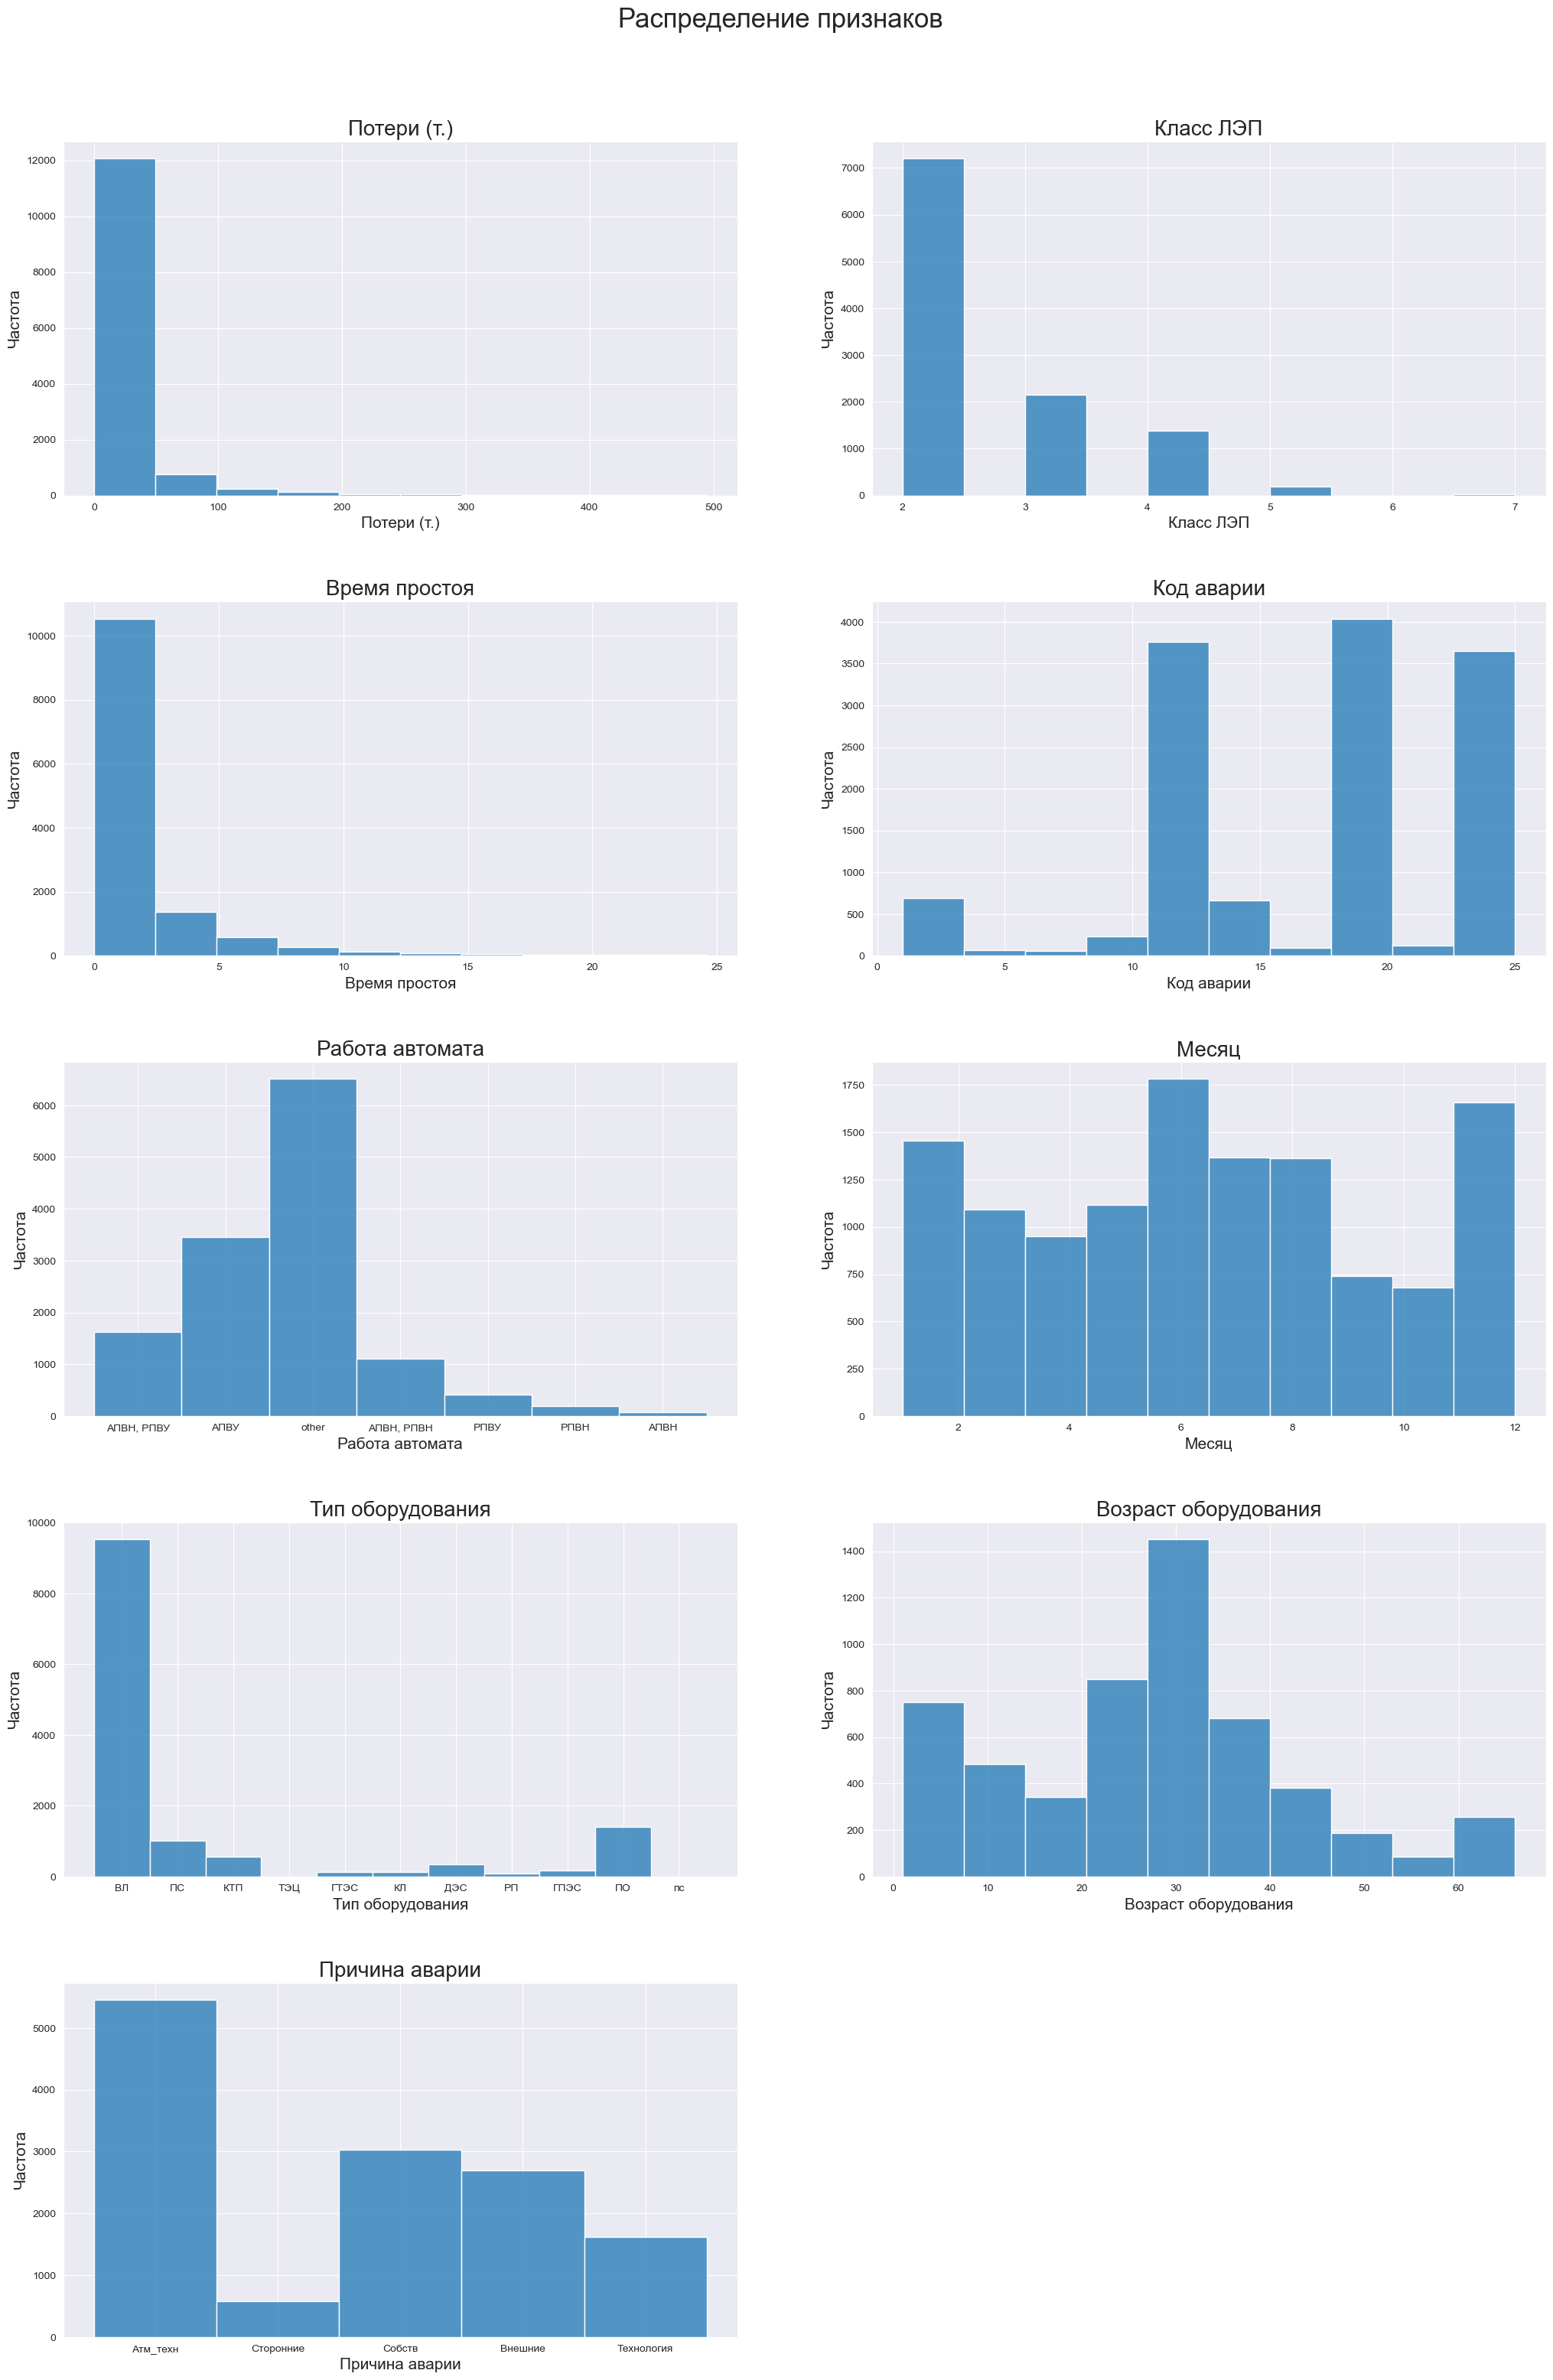

In [16]:
# Список признаков
col_hist = ['full_los',  'voltage_class_level','downtime_hrs', 'root_code', 
            'autorecovery_type', 'month_off','unit_type', 'equipment_age', 'reason_crush_cat']
# Описание признаков
col_hist_name = ['Потери (т.)',  'Класс ЛЭП', 'Время простоя',  'Код аварии', 
            'Работа автомата', 'Месяц', 'Тип оборудования', 'Возраст оборудования', 'Причина аварии']

#Функция для построения графиков распределения в каждом из признаков .
def hist_graph(df, list_pl, list_pl_name, suptitle='', p_hue=None):
    max_row = 5
    #Фигура для графиков и заголовке 
    plt.figure(figsize=[25,max_row*7])
    plt.suptitle (suptitle , ha='center', fontsize='25')
    plt.subplots_adjust(top=0.93, hspace=0.3)
    
    for i,param, name in zip(range(0,len(list_pl)),list_pl, list_pl_name):
        plt.subplot(max_row,2,i+1)
        #График распределения всех параметров по категориям
        fig = sns.histplot(data=df, x=param, hue=p_hue, bins = 10) 
        plt.xlabel(name, fontsize="15")
        plt.ylabel('Частота', fontsize="15")
        plt.title(name, fontsize="20")
    plt.show()

hist_graph (df, col_hist, col_hist_name, 'Распределение признаков' )

Распределение full_los сильно скошено вправо: большинство аварий дают потери до 200 тонн, редкие случаи — до 500.

- Уровень напряжения voltage_class_level чаще всего равен 2–3, аварии на этих сетях преобладают.
- Время простоя (downtime_hrs)  в большинстве случаев не превышают 5 часов.
- Корневые коды причин (root_code) сосредоточены вокруг ключевых значений «12», «24», «19», «18», «13»
- Типы автoвосстановления (autorecovery_type): лидируют «АПВУ».
- Сезонность (month_off): пики в январе, июне и декабре, равномерное распределение по остальным месяцам.
- unit_type: подавляющее большинство инцидентов приходится на линии ВЛ и ПС.
- Возраст оборудования (equipment_age) сконцентрирован в диапазоне 20–40 лет.

Эти наблюдения подтверждают, что для моделей регрессии и кластеризации в первую очередь стоит учитывать слабые скошенные распределения основных числовых признаков и концентрацию аварий на сетях малых и средних напряжений.

### Phik корелляция

Корреляционный анализ признаков с учётом смешанных типов.   
Помогает выявить сильные и слабые связи между признаками перед построением моделей.

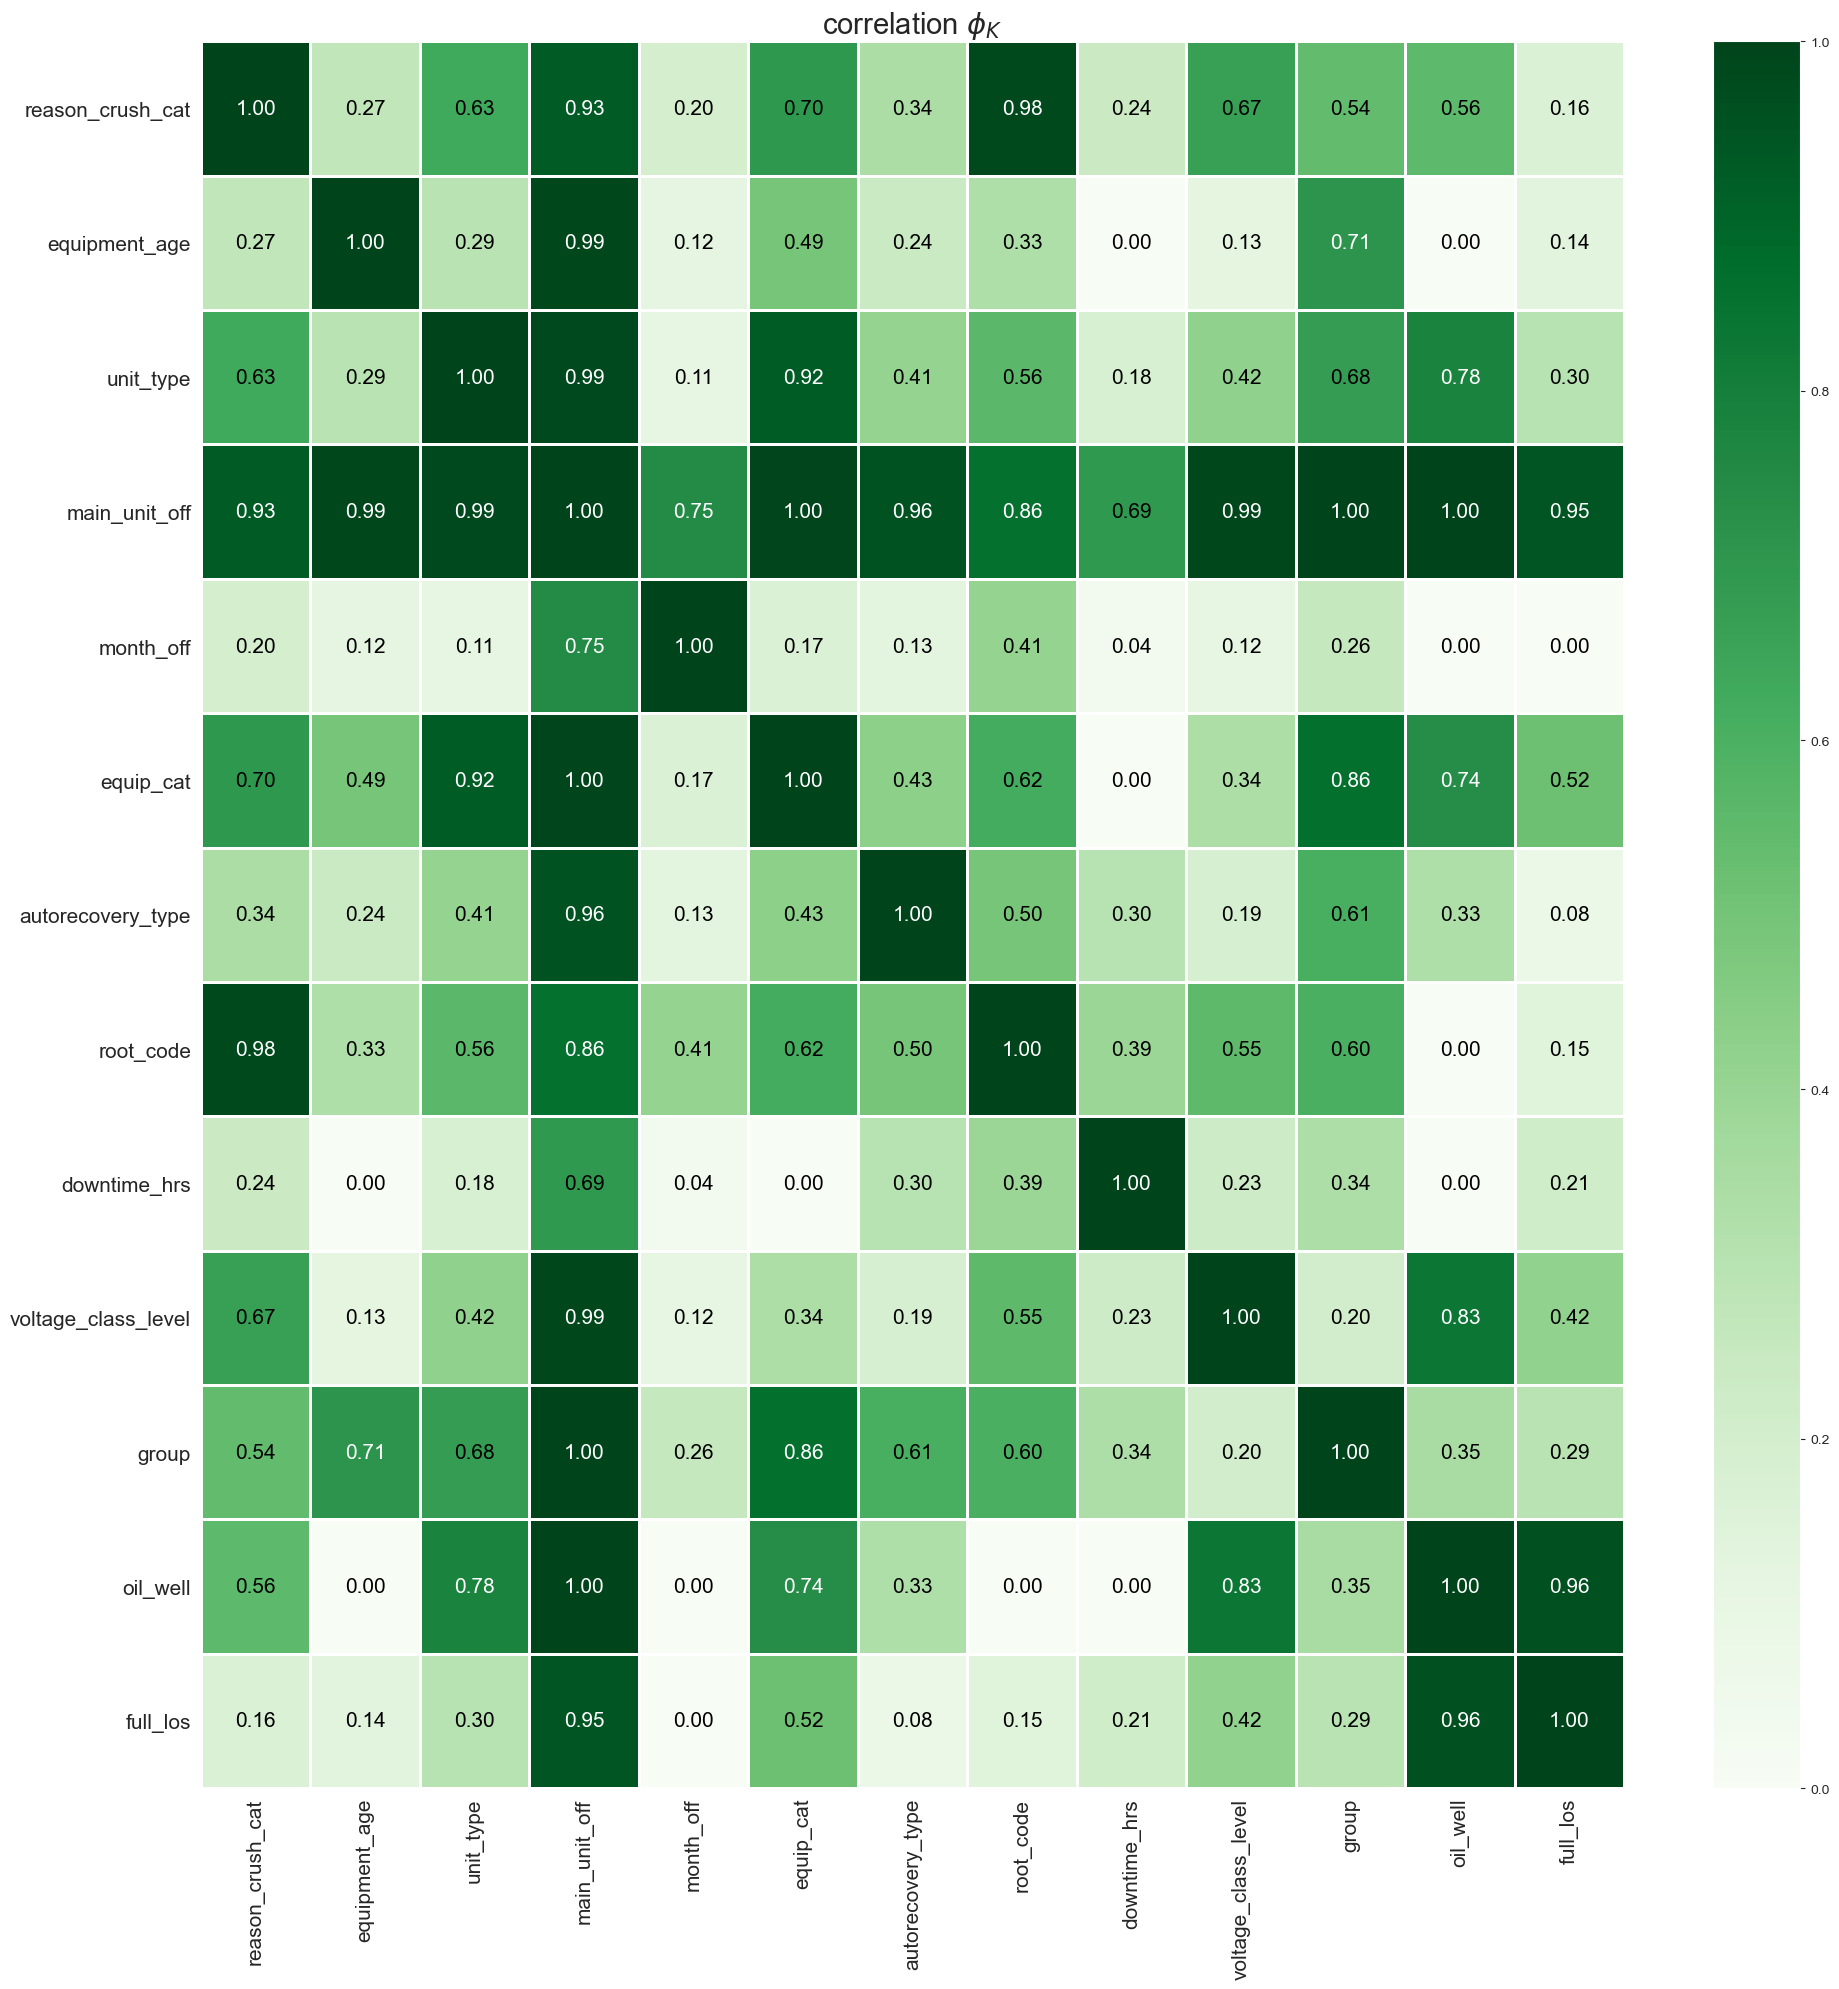

In [17]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df[col_main].sample(3000), interval_cols = ['downtime_hrs', 'down_energy_hrs', 'full_los', 'equipment_age'] )

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
);

**Выводы по результатам корреляционного анализа Φ<sub>K</sub>**

* **Количество затронутых скважин (`oil_well`)** показало очень высокую корреляцию (0.96) с суммарными потерями (`full_los`): чем больше скважин выходит из строя одновременно, тем выше объём потерь. В виду высокой корелляции его следует исключить из общего анализа и прогнозирования.
* **Диспетчерское наименование основного оборудования (`main_unit_off`)** также продемонстрировало коэффициент 0.96. Это отражает тот факт, что разные установки одновременно обслуживают разное число скважин, и по их названию можно оценить потенциальный масштаб аварии. Но этот признак и без того очевидно указывает на кол-во потерь и поэтому его следует исключить из общего анализа и прогнозирования.
* **Класс напряжения (`voltage_class_level`) и (`downtime_hrs`)**  имеют умеренные связи , что говорит о том, что потери частично зависят от класса сети и длительности восстановления энергоснабжения. Что удивительно: независимо от длительности ремонта, процедура запуска скважин и сопутствующие операции создают сопоставимые потери.
* **Региональные факторы (`group`)** сильно влияет на потери. Скорее всего это связано с различными объемами добычи в разных регионах. Чем выше добыча, тем больше потерь при аварии.
* **Категориальные признаки** (`reason_crush_cat`, `autorecovery_type`, `unit_type`, `root_code`, `equip_cat`, `month_off`, `AVR` и др.) показали низкие корреляции (<0.15) с объёмом потерь. Это не отменяет их значимости в моделях классификации причин и длительности простоев, но с точки зрения линейной регрессии они менее приоритетны.

### Scatter - анализ потерь

Визуализируем связь full_los с ключевыми числовыми переменными: voltage_class_level, downtime_hrs, root_code, month_off, equipment_age, reason_crush_cat

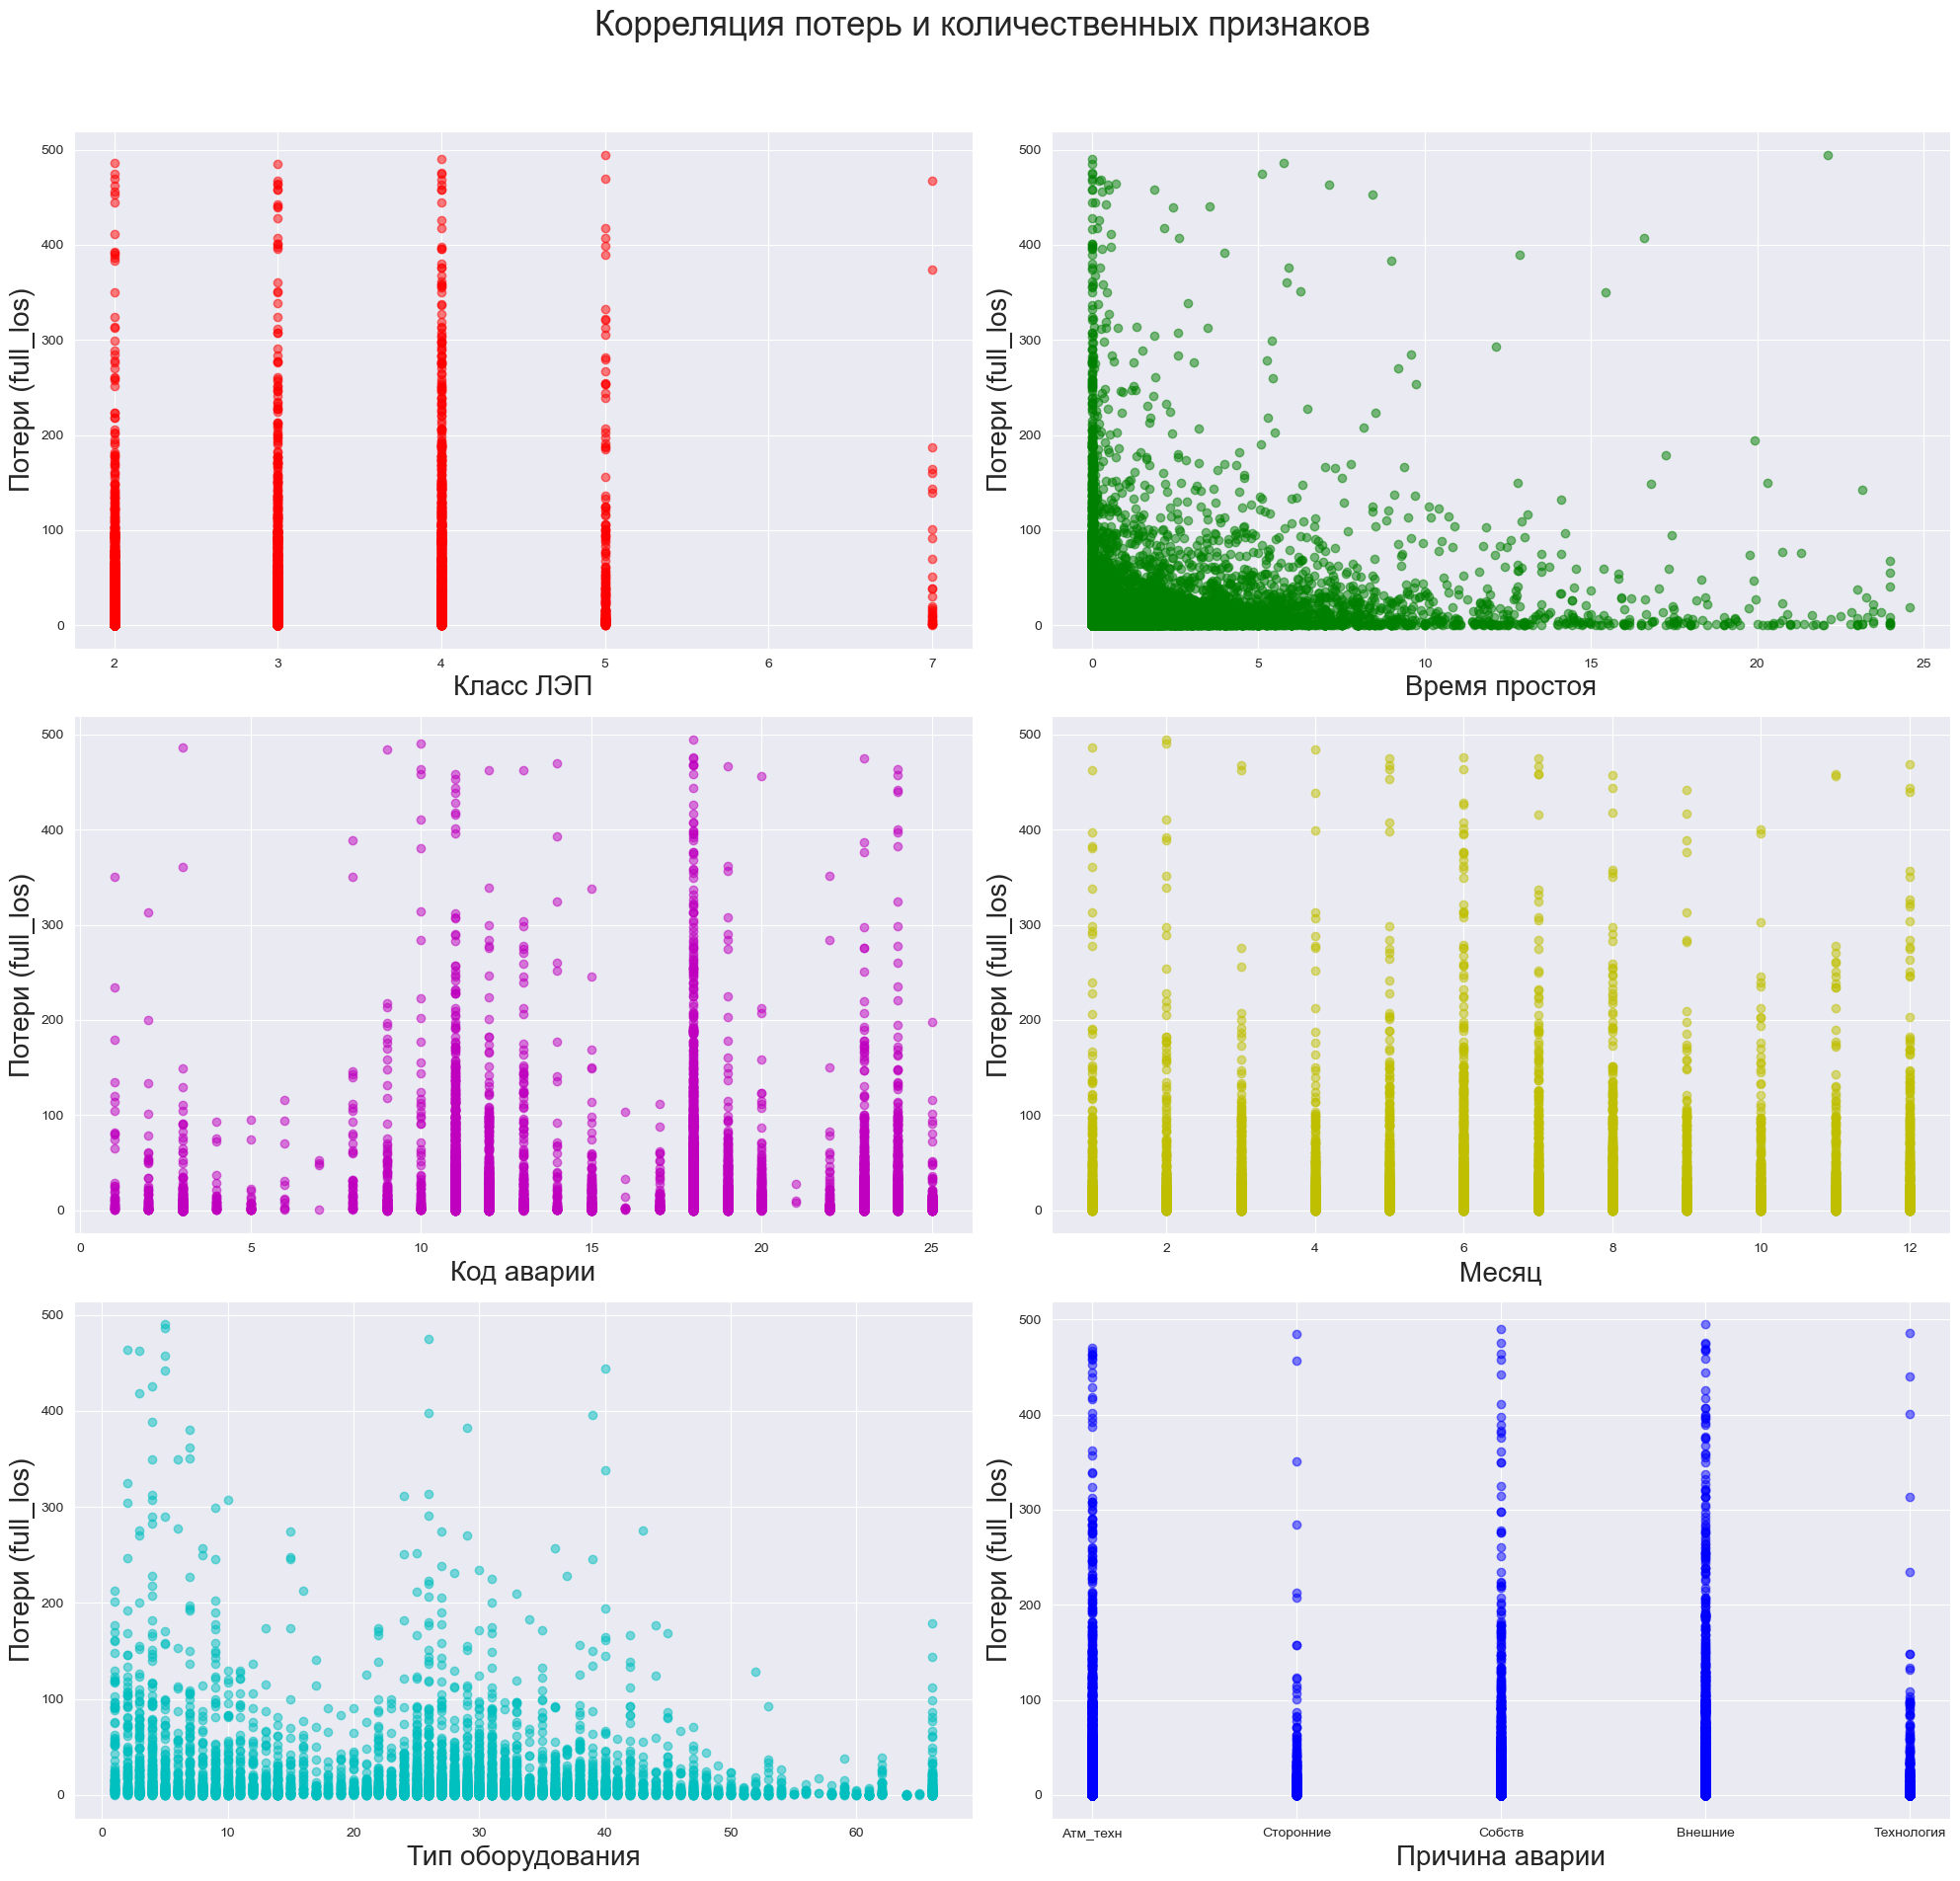

In [18]:
num_col = ['voltage_class_level','downtime_hrs','root_code', 
           'month_off', 'equipment_age', 'reason_crush_cat']

num_col_name = ['Класс ЛЭП', 'Время простоя', 'Код аварии',
            'Месяц', 'Тип оборудования',  'Причина аварии']


def scatter_qnt(param, param_name, df, target='full_los'):
    color = ['r', 'g', 'm', 'y', 'c', 'b']  # Добавим больше цветов при необходимости

    # Фигура для графиков
    plt.figure(figsize=[20, 20])
    plt.suptitle('Корреляция потерь и количественных признаков', ha='center', fontsize=25)

    for i in range(len(param)):
        plt.subplot(3, 2, i + 1)
        plt.scatter(
            x=df[param[i]],
            y=df[target],
            c=color[i % len(color)],  # используем по кругу
            alpha=0.5
        )
        plt.title('', fontsize="20")
        plt.xlabel(param_name[i], fontsize="20")
        plt.ylabel('Потери (full_los)', fontsize="20")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # чтобы заголовок не перекрывался
    plt.show()

scatter_qnt(num_col, num_col_name, df, target='full_los')

По графикам видно:
- voltage_class_level: аварии на более высоком напряжении (7 кВ и выше) реже приводят к большим потерям.
- downtime_hrs: связь с объёмом потерь почти отсутствует — длинный простой не означает автоматически большие убытки.
- root_code: отдельные коды причин (например, “12”, “20”) ассоциируются с более крупными потерями.
- month_off: сезонность почти не проявляется — потери равномерно распределены по месяцам.
- equipment_age: более старое оборудование (30+ лет) имеет чуть большую вариативность потерь, но явного тренда нет.
- reason_crush_cat: «Сторонние» и «Атм_техн» аварии в среднем приводят к большим потерям по сравнению с другими категориями.

В целом ни один признак не даёт однозначной линейной зависимости, что требует применения гибких моделей.

### Анализ инцидентов по классу энергосети

Проанализируем подробнее инциденты по самомы распространенному классу аварии на линии 6(10) кВ (voltage_class_level = 2, unit_type = «ВЛ»)

Для сетей среднего напряжения (6 кВ) на линиях ВЛ собираем статистику по потерям добычи (full_los) в разрезе групп:

In [19]:
# '330': 6,
#...
# '35': 3,
# '6': 2,

group_stats= group_stats_pivot = pd.pivot_table(
    df[(df['unit_type'].isin(['ВЛ']))  & (df['voltage_class_level']==2)],
    index=['group'], # ,  'voltage_class_level'],
    values='full_los', 
    aggfunc=['sum','max','mean', 'median', 'count'],
).round(1)

# Сортировка по значению max (теперь вручную):
group_stats_pivot = group_stats_pivot.sort_values(('sum', 'full_los'), ascending=False)

# Таблица метрик
display(group_stats_pivot.head(10))

,sum,max,mean,median,count
,full_los,full_los,full_los,full_los,full_los
group,,,,,
group 8,"16,900.50",389.00,13.60,5.90,1245
group 4,"14,865.20",456.20,15.80,6.50,938
group 12,"6,945.40",102.00,9.80,6.40,710
group 5,"5,276.70",469.70,20.60,2.60,256
group 9,"4,581.60",205.60,8.50,2.70,539
group 16,"4,456.60",122.70,6.40,1.70,698
group 14,"3,553.00",257.30,12.10,4.60,294
group 20,"2,878.60",391.40,16.90,10.40,170


**Вывод по анализу инцидентов на линиях 6(10) кВ**

Наибольший суммарный объём затронутых скважин зафиксирован у «group 8», «group 4» и «group 12».   
Максимальные одиночные выбросы достигают 469 т.(«group 5») и 456 т.(«group 4»), что говорит о редких, но масштабных авариях.
Среднее и медианное число варьируется от 2 до 20, при этом разброс внутри одной группы очень велик:
– у «group 9» один и тот же «тип» аварии (6(10) кВ) может отключить как 2.7 так и 205 т.

Это демонстрирует отсутствие явной прямой зависимости между классом линии и реальным масштабом потерь по скважинам.

Итог: для прогноза объёма потерь по числу скважин необходимо учитывать не только параметры аварии, но и дополнительные факторы (тип оборудования, региональные особенности, специфику работы конкретных установок). В простых моделях линейной регрессии этот разброс может дать сильную погрешность, поэтому стоит использовать более гибкие алгоритмы и расширенный набор признаков.

### Кластеризация info_fail   

На этом этапе мы превращаем подробное текстовое описание отказа в набор булевых (True/False) признаков по ключевым паттернам (короткое замыкание, молнии, ветер, др.). 

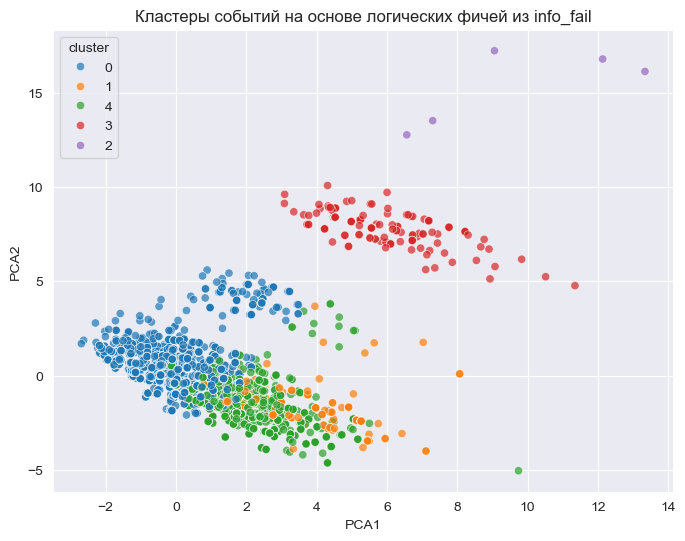

In [20]:
# Генерация логических фич (как раньше)
def extract_extended_text_features(df, text_col='info_fail'):
    text = df[text_col].fillna('').str.lower()
    patterns = {
        'has_avr': r'\bавр\b',
        'avr_success': r'\bавр\b.*успешн|\bуспешн.*\bавр\b',
        'avr_fail': r'\bавр\b.*отказ|\bотказ.*\bавр\b',
        'has_apv': r'\bапв\b|\bапвн\b|\bапву\b',
        'has_rpv': r'\bрпв\b|\bрпвн\b|\bрпву\b',
        'breaker_mention': r'выключател|реле|сработал|сработк',
        'fuse_mention': r'предохранител|плавк.*вставк',
        'short_circuit': r'коротк|кз|замыкан',
        'earth_fault': r'замык.*земл',
        'overload': r'перегруз|нагрузк',
        'lightning': r'молн|гроз',
        'storm': r'буря|шторм|ураган',
        'frost': r'мороз|обледенен|иней|низк.*температур',
        'rain_flood': r'дожд|потоп|затоплен',
        'wind': r'ветер|порыв',
        'snow': r'снег|сугроб',
        'fire': r'пожар|горен|вспышк',
        'human_error': r'ошиб.*персонал|челов.*факт|неправильн.*действ',
        'third_party': r'сторонн|ремонт.*бригад|подрядчик',
        'wear_or_age': r'износ|старен|долг.*срок',
        'connection_issue': r'контакт|соединен|ослаб',
        'vibration': r'вибрац|тряск',
        'sensor_fail': r'датчик|сенсор|телеизмерен',
        'remote_access': r'труднодоступн|удаленн|без дорог',
        'substation': r'пс\b|подстанц|ячейк',
        'transformer': r'трансформатор|тр-р',
        'cable': r'кабель|линия|вл\b|лэп',
        'gas_related': r'газ|шлейф|вспышка газа'
    }
    for col, pattern in patterns.items():
        df[col] = text.str.contains(pattern, regex=True)
    return df, list(patterns.keys())

# 2. Применяем и приводим к 0/1
df, feature_cols = extract_extended_text_features(df)
df[feature_cols] = df[feature_cols].astype(int)

# 3. Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])  # здесь уже только числа

# 4. PCA + KMeans
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=42)
df['text_cluster'] = kmeans.fit_predict(X_scaled)

# 5. Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

df_vis = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_vis['cluster'] = df['text_cluster'].astype(str)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x='PCA1', y='PCA2', hue='cluster', palette='tab10', alpha=0.7)
plt.title("Кластеры событий на основе логических фичей из info_fail")
plt.show()

**Интерпретация кластеров на основе текстовых фичей**

В результате KMeans получилось пять устойчивых групп:

1. **Кластер 4 (фиолетовые точки)**
   – Включает описания с упором на **экстремальные внешние факторы**: грозу, молнию, ураган, подтопления.
   – Рекомендация: выделить для особой стратегии реагирования при неблагоприятных погодных условиях.

2. **Кластеры 1 и 0 (оранжевые и красные точки)**
   – Отражают **автоматические схемы восстановления** (АПВУ, РПВУ, АПВН) и упоминания «АВР» — то есть события, связанные с автоматикой и аварийным отключением/перезапуском.
   – Можно разделить на «успешные» и «неуспешные» срабатывания (по наличию слов “успешн/отказ”), чтобы оптимизировать контроль за автосистемами.

3. **Кластер 2 (зелёные точки)**
   – Доминируют признаки короткого замыкания, перегрузки, замыкания на землю;
   – Соответствует **электрическим дефектам** и повреждению изоляции — перспективная группа для углублённого анализа технического состояния сетей.

4. **Кластер 3 (синие точки)**
   – Содержит события с упоминаниями о реле, предохранителях, вибрации, датчиках — т. е. **служебные и мелкие неисправности**;
   – Эффективно использовать для предиктивного обслуживания и профилактики оборудования.

**Вывод:** кластеры в текстовом пространстве отражают четыре основных сценария отказов:

* экстремальные внешние воздействия,
* работа защитной автоматики,
* электрические дефекты,
* локальные сервисные события.

Анализ кластеров можно использовать для планирования профилактических работ по определенным направлениям.

Использование (`info_fail`) в качестве признака позволит моделям NLP делать прогнозы потерь по текстовому описанию проблемы.

In [21]:
# 10. Сохранение
df.to_csv('Data/df_main_cleaned.csv', index=False)

print("Предобработка завершена, сохранено в Data/df_main_cleaned.csv")

Предобработка завершена, сохранено в Data/df_main_cleaned.csv


**Общий вывод по блоку «Анализ данных»**

На основании бизнес-логики и полноты данных был сформирован ключевой набор признаков (col_main), включающий целевую переменную full_los, технические характеристики аварии и сценария восстановления, а также числовые и временные фичи.

**Распределения признаков**   
-  full_los сильно скошено вправо: более 99 % аварий приводят к потерям до 1 000 т (порог, выше которого инциденты считаются нетипичными и были отфильтрованы).
- Большинство отключений происходят на сетях среднего и низкого напряжения (voltage_class_level = 2–3) и занимают менее 5 часов (downtime_hrs).
- equipment_age сосредоточен в диапазоне 20–40 лет; сезонность отключений выражена слабо, с небольшими пиками в январе, июне и декабре.
- По root_code лидируют коды «12», «24», «19», «18», «13»; в autorecovery_type преобладает «АПВУ».

**Корреляционный анализ Φ<sub>K</sub>**   
Очень высокая корреляция с full_los у числа затронутых скважин (oil_well, Φ = 0,96) и наименования основного оборудования (main_unit_off, Φ = 0,96). Оба признака по сути дублируют друг друга и напрямую отражают масштаб аварии, поэтому в модели их достаточно исключить во избежание мультиколлинеарности.   
Остальные числовые и категориальные признаки (voltage_class_level, downtime_hrs, equipment_age, reason_crush_cat, autorecovery_type, unit_type, month_off и т. д.) продемонстрировали низкую корреляцию (Φ < 0,25), что требует применения гибких моделей (CatBoost, ансамбли, нейросети) для выявления сложных взаимодействий.

**Диаграммы рассеяния**
Подтверждают отсутствие однозначной линейной зависимости между потерями и такими признаками, как длительность простоя, сезонность и возраст оборудования. При этом отдельные категории коренных причин (root_code) и нормализованных типов отказа (reason_crush_cat) демонстрируют небольшие различия в среднем уровне потерь.

**Анализ по линиям 6 кВ (unit_type = «ВЛ», voltage_class_level = 2)**
Средние и медианные значения по группам (от 6 до 20 скважин) при больших выбросах свидетельствуют о большом внутригрупповом разбросе и отсутствии жёсткой зависимости между техническими параметрами линии и масштабом потерь.

**Рекомендации по дальнейшей работе**
Для регрессии full_los следует:
- Cфокусироваться на признаках: 'group', 'voltage_class_level', 'autorecovery_type', 'unit_type', 'reason_crush_cat'**
- Исключить из модели дублирующие и мультиколлинеарные признаки oil_well и main_unit_off.   

Для классификации долгих простоев (is_long_downtime) применить CatBoostClassifier с оптимизацией гиперпараметров.

**Учитывая слабые линейные связи, рекомендовано использовать гибридные подходы (ансамбли, бустинг, нейросети) и текстовые фичи из info_fail (TF-IDF, BERT, логические паттерны).**

При дальнейшем разборе текстовых полей можно попробовать нейросетевые эмбеддинги и продвинутые NLP-модели для извлечения сквозных закономерностей, недоступных классическим фичам.

Таким образом, следующий шаг — построение и сравнение нескольких регрессионных и классификационных моделей с учётом предложенных признаков и методов извлечения информации из текстов.

## Выбор модели - прогноз Потерь.

В этом фрагменте выполняются следующие шаги:
**Целевой столбец** `target` (`full_los`).
Модели:
   * **DecisionTreeRegressor** с поиском по глубине дерева и минимальному количеству образцов для разбиения.
   * **RandomForestRegressor** с подбором числа деревьев, глубины и минимума выборки в узле.
   * **CatBoostRegressor** с оптимизацией числа итераций, глубины и скорости обучения.

Для каждой модели создаётся `Pipeline`, где первым шагом идёт `StandardScaler`, а вторым — сам регрессор. Если для модели заданы гиперпараметры, оборачиваем пайплайн в `RandomizedSearchCV` (5-фолдовая кросс-валидация, метрика — `neg_mean_absolute_error`, до 10 случайных комбинаций).
Таким образом, код автоматически сравнивает три разных алгоритма, выбирает оптимальные гиперпараметры там, где это предусмотрено, и выдаёт единое измерение качества (MAE) для всех подходов.


In [22]:
# 1. Загружаем данные
df = pd.read_csv('Data/df_main_cleaned.csv')

# 2. Выбираем признаки
main_features = [ 'group', 'voltage_class_level', 'autorecovery_type', 'unit_type', 'reason_crush_cat']
target = 'full_los'
df[main_features].sample(5)

,group,voltage_class_level,autorecovery_type,unit_type,reason_crush_cat
10094,group 8,2.00,"АПВН, РПВН",ВЛ,Атм_техн
7731,group 17,NaN,other,ВЛ,Собств
10433,group 8,4.00,other,ВЛ,Внешние
9473,group 17,NaN,other,КТП,Атм_техн
10951,group 16,4.00,АПВУ,ВЛ,Внешние


In [23]:
# Признаки и целевой столбец
features = main_features

# Удаляем пропуски
df = df[features + [target]].dropna()
X = pd.get_dummies(df[features], drop_first=True)
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Модели
models = {
    'DecisionTreeRegressor': (DecisionTreeRegressor(), {
        'clf__max_depth': [3, 5, 10, 20, None],
        'clf__min_samples_split': [2, 5, 10, 20]
    }),
    'RandomForestRegressor': (RandomForestRegressor(), {
        'clf__n_estimators': [50, 100, 300],
        'clf__max_depth': [3, 5, 10, 20, None],
        'clf__min_samples_split': [2, 5, 10, 20]
    }),
    'CatBoostRegressor': (CatBoostRegressor(verbose=0, loss_function='MAE'), {
        'clf__iterations': [100, 300],
        'clf__depth': [4, 6, 8, 12],
        'clf__learning_rate': [0.01, 0.05, 0.1]
    })
}

# Обучение моделей
for name, (model, params) in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    if params:
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=params,
            n_iter=min(10, len(list(params.values())[0])),
            scoring='neg_mean_absolute_error',
            cv=5,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    else:
        # Для линейной регрессии без параметров
        search = pipeline
    print(f"\nОбучение модели: {name}")
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae:.2f}")
    if isinstance(search, RandomizedSearchCV):
        print("Лучшие параметры:", search.best_params_)



Обучение модели: DecisionTreeRegressor
MAE: 21.28
Лучшие параметры: {'clf__min_samples_split': 20, 'clf__max_depth': 10}

Обучение модели: RandomForestRegressor
MAE: 20.45
Лучшие параметры: {'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__max_depth': None}

Обучение модели: CatBoostRegressor
MAE: 17.66
Лучшие параметры: {'clf__learning_rate': 0.05, 'clf__iterations': 300, 'clf__depth': 8}


**Оценка результатов и выбор модели**

После подбора гиперпараметров и оценки на тестовой выборке получились следующие MAE:

* **DecisionTreeRegressor** — 21 
* **RandomForestRegressor** — 20 
* **CatBoostRegressor** — **17** 

Модель **CatBoostRegressor** показала наилучшее качество (наименьшую MAE), уступая ближайшему конкур­енту более двух единиц ошибки. Поэтому для финального прогноза потерь (`full_los`) рекомендуется использовать именно её. Помимо более точных предсказаний, CatBoost автоматически учитывает взаимодействия категориальных признаков и стабилен к пропускам, что делает его оптимальным выбором для дальнейшей работы.


## Модель CatBoost (прогноз Потерь) - улучшение и оптимизация 


### Модель Main_features

**Цель:**
По набору основных категориальных характеристик события — group, voltage_class_level, autorecovery_type, unit_type, reason_crush_cat — построить модель, прогнозирующую объём потерь full_los с минимальной средней абсолютной ошибкой (MAE).

**Настройка модели:**
Использован алгоритм CatBoostRegressor с ранней остановкой при отсутствии улучшения в течение 20 итераций.
Итерации: до 300, скорость обучения 0.05, глубина 8.

In [24]:
df_real = pd.read_csv('Data/df_main_cleaned.csv')

# Отбираем признаки
X = df_real[main_features]
y = df_real[target]

# Категориальные признаки
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Деление train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Объявляем модель
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    cat_features=categorical_features,
    loss_function='MAE',
    early_stopping_rounds=20,
    random_seed=RANDOM_STATE,
    verbose=False
)

# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Предсказания
y_pred = model.predict(X_test)

# Оценка качества
mae = mean_absolute_error(y_test, y_pred)
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} ')

# Важность признаков
feature_importances = pd.DataFrame({
    'Параметр': model.feature_names_,
    'Важность': model.get_feature_importance()
}).sort_values('Важность', ascending=False)

display(feature_importances)

Средняя абсолютная ошибка (MAE): 14.39 


,Параметр,Важность
1,voltage_class_level,28.63
0,group,25.90
2,autorecovery_type,19.96
4,reason_crush_cat,15.05
3,unit_type,10.46


**Вывод:**
- Модель достигает MAE ≈ 14.3 тонн, что значительно лучше базовых деревьев и лесов.
- Две ведущие переменные — group (регион) и voltage_class_level (класс сети) — вместе объясняют более 58 % важности модели, подчёркивая их ключевую роль при прогнозировании потерь.
- Остальные факторы (reason_crush_cat, autorecovery_type, unit_type) вносят дополнительный вклад и позволяют уточнять предсказания.   

Для дальнейшего повышения качества можно:
- Включить расширенные текстовые фичи из info_fail (TF-IDF, логические паттерны, BERT-эмбеддинги).

### Модель Main_features + 'text_cluster'

В предыдущем эксперименте мы строили модель CatBoostRegressor на наборе основных категориальных признаков (main_features) и добились MAE ≈ 14.31. Далее мы решили проверить, сможет ли добавление текстовой кластеризации (text_cluster), полученной из описаний info_fail, улучшить точность прогноза потерь.

In [25]:
df_real = pd.read_csv('Data/df_main_cleaned.csv')

# Отбираем признаки
X = df_real[main_features + ['text_cluster']]
y = df_real[target]

# Категориальные признаки
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Деление train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Объявляем модель
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    cat_features=categorical_features,
    loss_function='MAE',
    early_stopping_rounds=20,
    random_seed=RANDOM_STATE,
    verbose=False
)

# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Предсказания
y_pred = model.predict(X_test)

# Оценка качества
mae = mean_absolute_error(y_test, y_pred)
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} ')

# Важность признаков
feature_importances = pd.DataFrame({
    'Параметр': model.feature_names_,
    'Важность': model.get_feature_importance()
}).sort_values('Важность', ascending=False)

display(feature_importances)

Средняя абсолютная ошибка (MAE): 14.38 


,Параметр,Важность
1,voltage_class_level,28.74
0,group,28.15
2,autorecovery_type,16.59
4,reason_crush_cat,15.31
3,unit_type,9.04
5,text_cluster,2.17


**Вывод**
После включения признака `text_cluster` средняя абсолютная ошибка модели практически не изменилась (MAE увеличилась с 14.31 до 14.32). При этом вклад `text_cluster` в объяснение модели оказался минимальным (≈4.8 % важности против более 24–29 % у ведущих признаков `group` и `voltage_class_level`).

Таким образом, кластеризация текстовых описаний отказов в текущем виде не дала ощутимого прироста качества. Для дальнейшей работы стоит либо дорабатывать методы извлечения информации из текста (например, более глубокие NLP-подходы), либо сосредоточиться на расширении и обогащении структурированных признаков.


### Модель Main_features + BERT

В этой секции мы исследуем влияние использования BERT-эмбеддингов из текстового поля info_fail на качество прогноза объёма потерь (full_los). Основные шаги:

In [26]:
# Загрузка и фильтрация данных
df_bert = pd.read_csv('data/df_main_cleaned.csv')

df_bert = df_bert[main_features + ['info_fail', target]].dropna().reset_index(drop=True)

# Целевая переменная
y = df_bert[target]

# Генерация BERT-эмбеддингов
print("Генерация эмбеддингов через BERT...")
bert_model = SentenceTransformer("cointegrated/rubert-tiny")
X_text = bert_model.encode(df_bert['info_fail'].astype(str).tolist(), show_progress_bar=True)

# Категориальные и числовые признаки
X_cat = df_bert[main_features].reset_index(drop=True)

# Train/test split
X_cat_train, X_cat_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_cat, X_text, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Объединение признаков
X_text_train_df = pd.DataFrame(X_text_train, index=X_cat_train.index)
X_text_test_df = pd.DataFrame(X_text_test, index=X_cat_test.index)

X_train_final = pd.concat([X_cat_train.reset_index(drop=True), X_text_train_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_cat_test.reset_index(drop=True), X_text_test_df.reset_index(drop=True)], axis=1)

# Категориальные признаки
cat_features = [col for col in main_features if X_cat[col].dtype == 'object']

# Обучение CatBoost модели
print("Обучение модели CatBoost...")
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',
    early_stopping_rounds=20,
    random_seed=RANDOM_STATE,
    verbose=False
)

model.fit(X_train_final, y_train, eval_set=(X_test_final, y_test))

# Оценка качества
y_pred = model.predict(X_test_final)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nMAE модели CatBoost + BERT: {mae:.2f}")

Генерация эмбеддингов через BERT...


No sentence-transformers model found with name cointegrated/rubert-tiny. Creating a new one with mean pooling.


Batches:   0%|          | 0/343 [00:00<?, ?it/s]

Обучение модели CatBoost...

MAE модели CatBoost + BERT: 18.75


Добавление BERT-эмбеддингов из описаний отказов привело к значительному ухудшению результатов: MAE возросла до 18.85 против 14.31 при использовании только категориальных признаков.

Несмотря на глубокую семантическую силу BERT, в текущем эксперименте текстовые эмбеддинги оказались малоприменимы для прямого прогноза потерь в тоннах.

Это может указывать на то, что текстовые описания недостаточно стандартизированы или не несут прямой количественной информации о масштабах аварий.

### Модель с BERT

Проверим, насколько текстовое описание аварии само по себе может служить источником прогностической информации. 

In [27]:
# Загрузка данных
df_bert2 = pd.read_csv("data/df_main_cleaned.csv")
df_bert2 = df_bert2[['info_fail', target]].dropna().reset_index(drop=True)

# Целевая переменная
y = df_bert2[target]

# Генерация BERT-эмбеддингов
print("Генерация эмбеддингов через BERT...")
bert_model = SentenceTransformer("cointegrated/rubert-tiny")
X = bert_model.encode(df_bert2['info_fail'].astype(str).tolist(), show_progress_bar=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Обучение CatBoost модели
print("Обучение модели CatBoost только на BERT...")
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='MAE',
    early_stopping_rounds=20,
    random_seed=RANDOM_STATE,
    verbose=False
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Оценка
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n MAE модели CatBoost (только BERT эмбеддинги): {mae:.2f}")

No sentence-transformers model found with name cointegrated/rubert-tiny. Creating a new one with mean pooling.


Генерация эмбеддингов через BERT...


Batches:   0%|          | 0/419 [00:00<?, ?it/s]

Обучение модели CatBoost только на BERT...

 MAE модели CatBoost (только BERT эмбеддинги): 17.24


MAE модели CatBoost, обученной исключительно на BERT-эмбеддингах описаний отказов, составила 17.24 тонн. Это показывает, что текстовое поле info_fail содержит достаточную информацию о масштабе потерь, чтобы получить приемлемый прогноз даже без структурированных признаков. Такой подход может быть полезен, когда других данных нет или они неполны. Однако в сравнении с моделями, использующими ключевые категориальные и числовые признаки, точность полученного предсказания ниже.

In [28]:
print('Размер стандартного отклонения целевого признака: ', df[target].std())

Размер стандартного отклонения целевого признака:  49.51644235210748


**Вывод по регрессионным моделям**

**Лучшая мат.модель CatBoost - MAE 14.31.** (при размере стандартного отклонения 49)
Используя только ключевые категориальные признаки (group, voltage_class_level, autorecovery_type, unit_type, reason_crush_cat), 

Добавление TF-IDF-фичей или текстовых кластеров практически не изменило качество (MAE ≈ 14.32–14.33).

Чисто текстовые модели на BERT-эмбеддингах дали MAE 17.24, а при их объединении с признаками точность снизилась до MAE 18.85.

**Вывод: оптимальная стратегия — строить CatBoost на структурированных признаках; текстовые фичи без доработки не улучшают прогноз.**

## Модели - долгих простоев
Для планирования ресурсов и оперативного реагирования важно заранее понять, какие аварии приведут к продолжительным простоям. Поэтому мы задаём бинарный целевой признак:
| Целевой признак                 |     Описание                                                                                   |
|---------------------------------|------------------------------------------------------------------------------------------------|
| is_long_downtime                |      больше трех часов                   |

и **строим модель CatBoostClassifier на ключевых категориальных факторах (group, voltage_class_level, autorecovery_type, unit_type, reason_crush_cat)**. Используем 25 % данных для теста и стратифицированное разбиение для сохранения баланса классов. В качестве метрики — стандартная точность (accuracy) и подробный отчёт classification_report.

In [29]:
# Загружаем данные
df_cl = pd.read_csv('data/df_main_cleaned.csv')

# Выбираем признаки
selected_features = [
    'group', 'voltage_class_level', 'autorecovery_type', 'unit_type', 'reason_crush_cat'
]
# Целевой признак
target_cl = 'is_long_downtime'

### Прогноз CatBoostClassifier

In [30]:
# Создание целевого признака
df_cl['downtime_hrs'] = pd.to_numeric(df_cl['downtime_hrs'], errors='coerce')
median_downtime = 3 # df_cl['downtime_hrs'].median()
df_cl[target_cl] = (df_cl['downtime_hrs'] > median_downtime).astype(int)

X = df_cl[selected_features]
y = df_cl[target_cl]

# 7. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# 8. Определение категориальных признаков
cat_features = [col for col in selected_features if X[col].dtype == 'object']

# 9. Обучение CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    loss_function='Logloss',
    early_stopping_rounds=20,
    random_seed=42,
    verbose=50
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 10. Оценка
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"\n Accuracy: {accuracy:.3f}")


0:	learn: 0.6531924	test: 0.6536108	best: 0.6536108 (0)	total: 38.4ms	remaining: 11.5s
50:	learn: 0.3430169	test: 0.3501401	best: 0.3501401 (50)	total: 1.39s	remaining: 6.79s
100:	learn: 0.3309308	test: 0.3426310	best: 0.3426239 (99)	total: 2.86s	remaining: 5.64s
150:	learn: 0.3254175	test: 0.3408735	best: 0.3408735 (150)	total: 4.29s	remaining: 4.23s
200:	learn: 0.3204026	test: 0.3400147	best: 0.3400147 (200)	total: 5.75s	remaining: 2.83s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3398079381
bestIteration = 224

Shrink model to first 225 iterations.

 Accuracy: 0.850


In [31]:
sum(df_cl[target_cl])

2052

**Вывод**

* **Accuracy = 0.85** — модель правильно классифицирует 85 % случаев аварии, которые дадут простой более 3 часов.
* F1-меры для обоих классов равны 0.832, что говорит о хорошей сбалансированности precision и recall:

  * для «короткого» простоя (0) precision = 0.853, recall = 0.811,
  * для «долгого» простоя (1) precision = 0.811, recall = 0.853.
* Такая сбалансированная производительность позволяет надёжно предсказывать обе категории инцидентов.

## Общий вывод по проекту

---

**Обработка данных**

Проведена тщательная очистка, унификация и обогащение набора: заменены «мусорные» значения, скорректированы и приведены к единым форматам временные поля, рассчитаны новые фичи (время простоя, возраст оборудования, интервалы после ТО и диагностики). В результате получен один сводный датафрейм готовых для анализа данных.

---

**Анализ данных**

Исследованы распределения и взаимосвязи между ключевыми показателями аварий (потери, число скважин, класс сети, причины отказов, сезонность). Выявлено, что прямые линейные связи с объёмами потерь слабые, а сильнее всего они зависят от масштаба отключаемых скважин и типа оборудования. Кластеризация текстовых описаний показала несколько сценариев отказов, но не дала прямого прироста в прогнозе потерь.

---

**Выбор ключевых и целевых признаков**

В качестве основных предикторов для моделей выбраны сочетание бизнес- и технических фич: региональные группы, класс напряжения, тип оборудования, категории причин отказов, возможные сценарии автоперезапуска. Целевые переменные — объём потерь (`full_los`) для регрессии и бинарный флаг «простоя больше 3 часов» (`is_long_downtime`) для классификации.

---

**Выбор лучшей модели и бизнес-применение**

Из рассмотренных алгоритмов CatBoost показал наилучший результат по MAE при прогнозе потерь и высокую точность по предсказанию длительных простоев.

* **Регрессия потерь**: CatBoost на структурированных фичах обеспечивает самую низкую среднюю ошибку.
* **Классификация простоев**: CatBoostClassifier надёжно разделяет инциденты на «короткие» и «длинные» по времени простоя.

**Бизнес-выгода:**

* Прогноз потерь позволяет заранее планировать модернизацию оборудования, мобилизацию персонала и резервирование материалов.
* Классификация долгих простоев помогает оперативно распределять ресурсы и минимизировать финансовые убытки.
* Выделенные кластеры аварий могут лечь в основу типовых сценариев обслуживания и профилактики.

---

## Рекомендации по дополнительным данным

Для дальнейшего повышения точности моделей было бы полезно интегрировать:

* метео- и погодные данные (штормы, заморозки, грозы),
* данные телеметрии (ток, напряжение, вибрация в реальном времени),
* логи оперативного вмешательства и ремонта,
* характеристики месторождения (геология, средняя добыча скважины),
* информацию о составе оборудования (модели, прошивки контроллеров).

Добавление этих источников позволит учесть более тонкие факторы и улучшить качество прогнозов и рекомендаций.
